# Creating Our Dataset and Applying Our Transformer

In this notebook, we:
- download friends-corpus
- apply our Transformer, Genderromantic, to it
- analyze the resulting measures

In [1]:
!python3 -m pip install -r requirements.txt

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import convokit
convokit

<module 'convokit' from '/home/kcs3au/cs2/Cornell-Conversational-Analysis-Toolkit/convokit/__init__.py'>

In [3]:
from convokit import Corpus

# Download locally stored corpus

In [4]:
corpus = Corpus(filename='./datasets/friends-corpus/corpus')

In [5]:
utt_ids=corpus.get_utterance_ids()
utt0=corpus.get_utterance(utt_ids[0])
utt0

Utterance({'id': 's01_e01_c01_u001', 'user': User([('name', 'Monica Geller')]), 'root': 's01_e01_c01_u001', 'reply_to': None, 'timestamp': None, 'text': "There's nothing to tell! He's just some guy I work with!", 'meta': {'tokens': [['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']], 'character_entities': [[], [[0, 1, 'Paul the Wine Guy'], [4, 5, 'Paul the Wine Guy'], [5, 6, 'Monica Geller']]], 'emotion': None, 'caption': None, 'transcript_with_note': None, 'tokens_with_note': None}})

# Use locally defined Transformer

In [6]:
from convokit import Genderromantic
Genderromantic

convokit.genderromantic.genderromantic.Genderromantic

In [7]:
grr = Genderromantic()

In [8]:
transformed_corpus = grr.fit_transform(corpus)

61338it [00:07, 8718.52it/s]


In [9]:
transformed_corpus.get_conversation('s01_e01_c01_u001')

Conversation({'_owner': <convokit.model.corpus.Corpus object at 0x7f343c117c50>, '_id': 's01_e01_c01_u001', '_utterance_ids': ['s01_e01_c01_u001', 's01_e01_c01_u002', 's01_e01_c01_u003', 's01_e01_c01_u004', 's01_e01_c01_u006', 's01_e01_c01_u007', 's01_e01_c01_u008', 's01_e01_c01_u010', 's01_e01_c01_u011', 's01_e01_c01_u012', 's01_e01_c01_u013', 's01_e01_c01_u014', 's01_e01_c01_u015', 's01_e01_c01_u016', 's01_e01_c01_u017', 's01_e01_c01_u018', 's01_e01_c01_u019', 's01_e01_c01_u021', 's01_e01_c01_u022', 's01_e01_c01_u023', 's01_e01_c01_u024', 's01_e01_c01_u025', 's01_e01_c01_u026', 's01_e01_c01_u027', 's01_e01_c01_u028', 's01_e01_c01_u029', 's01_e01_c01_u030', 's01_e01_c01_u031', 's01_e01_c01_u032', 's01_e01_c01_u033', 's01_e01_c01_u034', 's01_e01_c01_u035', 's01_e01_c01_u036', 's01_e01_c01_u037', 's01_e01_c01_u038', 's01_e01_c01_u039', 's01_e01_c01_u040', 's01_e01_c01_u041', 's01_e01_c01_u042', 's01_e01_c01_u044', 's01_e01_c01_u045', 's01_e01_c01_u047', 's01_e01_c01_u048', 's01_e01_c01_

# Running Statistics on Utterance-Level

In [10]:
# Original Genderromantic

male_speaking = 0
male_speaking_about_female = 0
male_speaking_about_female_romantic = 0

male_speaking_not_about_female = 0

female_speaking = 0
female_speaking_about_male = 0
female_speaking_about_male_romantic = 0

female_speaking_not_about_male = 0

romantic = 0
not_romantic = 0


utterance_ids = transformed_corpus.get_utterance_ids()
assert len(utterance_ids) == 61338

for uid in utterance_ids:
    utt=transformed_corpus.get_utterance(uid)
    
    # First get whether it's a male or female speaker
    speaker_gender = utt.user.meta['gender']
    if speaker_gender == "male":
        male_speaking += 1
    if speaker_gender == "female":
        female_speaking += 1
        
    # Then get whether the utterance is a male speaking about a female:
    mf2=utt.meta["male_about_female"]
    if mf2:
        male_speaking_about_female += 1
        # And whether it was romantic
        if utt.meta["contains_romantic"]:
            male_speaking_about_female_romantic += 1
    else:
        male_speaking_not_about_female += 1
        
    # Then get whether the utterance is a female speaking about a male:
    fm2=utt.meta["female_about_male"]
    if fm2:
        female_speaking_about_male += 1
        # And whether it was romantic
        if utt.meta["contains_romantic"]:
            female_speaking_about_male_romantic += 1
    else:
        female_speaking_not_about_male += 1
        
    # Then register whether the utt is romantic, period.
    rom=utt.meta["contains_romantic"]
    if rom:
        romantic += 1
    else:
        not_romantic += 1

#Creating Percentages - help with graphs later
perc_male_about_female=(float(male_speaking_about_female) / float(male_speaking))*100
perc_male_about_female_rom=(float(male_speaking_about_female_romantic) / float(male_speaking_about_female))*100
perc_female_about_male=(float(female_speaking_about_male) / float(female_speaking))*100
perc_female_about_male_rom=(float(female_speaking_about_male_romantic) / float(female_speaking_about_male))*100
    
print('male_speaking: ', male_speaking)
print('male_speaking_about_female: ', male_speaking_about_female)
print('male_speaking_about_female_romantic: ', male_speaking_about_female_romantic)
print('pct male utterances about females', perc_male_about_female)
print('pct male utterances about females that are romantic', perc_male_about_female_rom)
print('male_speaking_not_about_female: ', male_speaking_not_about_female)
print('\n')
print('female_speaking: ', female_speaking)
print('female_speaking_about_male: ', female_speaking_about_male)
print('female_speaking_about_male_romantic: ', female_speaking_about_male_romantic)
print('pct female utterances about males', perc_female_about_male)
print('pct female utterances about males that are romantic', perc_female_about_male_rom)
print('female_speaking_not_about_male: ', female_speaking_not_about_male)
print('\n')
print('romantic: ', romantic)
print('not_romantic: ', not_romantic)




male_speaking:  20745
male_speaking_about_female:  3131
male_speaking_about_female_romantic:  523
pct male utterances about females 15.092793444203423
pct male utterances about females that are romantic 16.703928457361865
male_speaking_not_about_female:  58207


female_speaking:  28264
female_speaking_about_male:  3651
female_speaking_about_male_romantic:  589
pct female utterances about males 12.917492216246815
pct female utterances about males that are romantic 16.132566420158863
female_speaking_not_about_male:  57687


romantic:  6602
not_romantic:  54736


In [11]:
# Pronoun-only 
male_speaking = 0
male_speaking_about_female = 0
male_speaking_about_female_romantic = 0

male_speaking_not_about_female = 0

female_speaking = 0
female_speaking_about_male = 0
female_speaking_about_male_romantic = 0

female_speaking_not_about_male = 0

romantic = 0
not_romantic = 0


utterance_ids = transformed_corpus.get_utterance_ids()
assert len(utterance_ids) == 61338

for uid in utterance_ids:
    utt=transformed_corpus.get_utterance(uid)
    
    # First get whether it's a male or female speaker
    speaker_gender = utt.user.meta['gender']
    if speaker_gender == "male":
        male_speaking += 1
    if speaker_gender == "female":
        female_speaking += 1
        
    # Then get whether the utterance is a male speaking about a female:
    mf2=utt.meta["male_about_female"]
    if mf2:
        male_speaking_about_female += 1
        # And whether it was romantic
        if utt.meta["contains_romantic"]:
            male_speaking_about_female_romantic += 1
    else:
        male_speaking_not_about_female += 1
        
    # Then get whether the utterance is a female speaking about a male:
    fm2=utt.meta["female_about_male"]
    if fm2:
        female_speaking_about_male += 1
        # And whether it was romantic
        if utt.meta["contains_romantic"]:
            female_speaking_about_male_romantic += 1
    else:
        female_speaking_not_about_male += 1
        
    # Then register whether the utt is romantic, period.
    rom=utt.meta["contains_romantic"]
    if rom:
        romantic += 1
    else:
        not_romantic += 1

#Creating Percentages - help with graphs later
perc_male_about_female=(float(male_speaking_about_female) / float(male_speaking))*100
perc_male_about_female_rom=(float(male_speaking_about_female_romantic) / float(male_speaking))*100
perc_female_about_male=(float(female_speaking_about_male) / float(female_speaking))*100
perc_female_about_male_rom=(float(female_speaking_about_male_romantic) / float(female_speaking))*100
    
print('male_speaking: ', male_speaking)
print('male_speaking_about_female: ', male_speaking_about_female)
print('male_speaking_about_female_romantic: ', male_speaking_about_female_romantic)
print('pct male utterances about females', perc_male_about_female)
print('pct male utterances about females that are romantic', perc_male_about_female_rom)
print('male_speaking_not_about_female: ', male_speaking_not_about_female)
print('\n')
print('female_speaking: ', female_speaking)
print('female_speaking_about_male: ', female_speaking_about_male)
print('female_speaking_about_male_romantic: ', female_speaking_about_male_romantic)
print('pct female utterances about males', perc_female_about_male)
print('pct female utterances about males that are romantic', perc_female_about_male_rom)
print('female_speaking_not_about_male: ', female_speaking_not_about_male)
print('\n')
print('romantic: ', romantic)
print('not_romantic: ', not_romantic)




male_speaking:  20745
male_speaking_about_female:  3131
male_speaking_about_female_romantic:  523
pct male utterances about females 15.092793444203423
pct male utterances about females that are romantic 2.521089419137142
male_speaking_not_about_female:  58207


female_speaking:  28264
female_speaking_about_male:  3651
female_speaking_about_male_romantic:  589
pct female utterances about males 12.917492216246815
pct female utterances about males that are romantic 2.0839230116048686
female_speaking_not_about_male:  57687


romantic:  6602
not_romantic:  54736


# Utterances by Season

In [69]:
# Utterances by Season (Original Genderromantic) 
convo={}
convo1={}
male_speaking = 0
male_speaking_about_female = 0
male_speaking_about_female_romantic = 0

male_speaking_not_about_female = 0

male_speaking_about_male=0
male_speaking_about_male_romantic=0
male_speaking_not_about_male=0

female_speaking = 0
female_speaking_about_male = 0
female_speaking_about_male_romantic = 0

female_speaking_not_about_male = 0

female_speaking_about_female=0
female_speaking_about_female_romantic=0
female_speaking_not_about_female=0

romantic = 0
not_romantic = 0
tot_utt=0

utterance_ids = transformed_corpus.get_utterance_ids()
current_season=utterance_ids[0][:3]
current_season2=1
for uid in utterance_ids:
    utt=transformed_corpus.get_utterance(uid)
    if uid[:3]==current_season:
        tot_utt=tot_utt+1    
        # First get whether it's a male or female speaker
        speaker_gender = utt.user.meta['gender']
        if speaker_gender == "male":
            male_speaking += 1
        if speaker_gender == "female":
            female_speaking += 1

        # Then get whether the utterance is a male speaking about a female:
        mf2=utt.meta["male_about_female"]
        if mf2:
            male_speaking_about_female += 1
            # And whether it was romantic
            if utt.meta["contains_romantic"]:
                male_speaking_about_female_romantic += 1
        else:
            male_speaking_not_about_female += 1

        # Then get whether the utterance is a female speaking about a male:
        fm2=utt.meta["female_about_male"]
        if fm2:
            female_speaking_about_male += 1
            # And whether it was romantic
            if utt.meta["contains_romantic"]:
                female_speaking_about_male_romantic += 1
        else:
            female_speaking_not_about_male += 1

        # Then get whether the utterance is a male speaking about a male:
        mm2=utt.meta["male_about_male"]
        if mm2:
            male_speaking_about_male += 1
            # And whether it was romantic
            if utt.meta["contains_romantic"]:
                male_speaking_about_male_romantic += 1
        else:
            male_speaking_not_about_male += 1

        # Then get whether the utterance is a female speaking about a female:
        ff2=utt.meta["female_about_female"]
        if ff2:
            female_speaking_about_female += 1
            # And whether it was romantic
            if utt.meta["contains_romantic"]:
                female_speaking_about_female_romantic += 1
        else:
            female_speaking_not_about_female += 1

        # Then register whether the utt is romantic, period.
        rom=utt.meta["contains_romantic"]
        if rom:
            romantic += 1
        else:
            not_romantic += 1
    else: 
        current_season=uid[:3]
        current_season2=current_season2+1
        
        male_speaking = 0
        male_speaking_about_female = 0
        male_speaking_about_female_romantic = 0

        male_speaking_not_about_female = 0

        male_speaking_about_male=0
        male_speaking_about_male_romantic=0
        male_speaking_not_about_male=0

        female_speaking = 0
        female_speaking_about_male = 0
        female_speaking_about_male_romantic = 0

        female_speaking_not_about_male = 0

        female_speaking_about_female=0
        female_speaking_about_female_romantic=0
        female_speaking_not_about_female=0

        romantic = 0
        not_romantic = 0
    
        tot_utt=0 
        
    convo1[current_season2] = {'current_season': current_season, 'tot_utt': tot_utt, 'male_speaking_about_male_romantic': male_speaking_about_male_romantic, 'male_speaking_about_female_romantic': male_speaking_about_female_romantic, 'female_speaking_about_female_romantic': female_speaking_about_female_romantic, 'female_speaking_about_male_romantic': female_speaking_about_male_romantic}



In [70]:
print(convo1[3])

{'current_season': 's03', 'tot_utt': 6495, 'male_speaking_about_male_romantic': 89, 'male_speaking_about_female_romantic': 171, 'female_speaking_about_female_romantic': 69, 'female_speaking_about_male_romantic': 182}


In [92]:
r= [(current_season2, convo1[current_season2]['tot_utt'], convo1[current_season2]['male_speaking_about_male_romantic'], convo1[current_season2]['male_speaking_about_female_romantic'], convo1[current_season2]['female_speaking_about_female_romantic'], convo1[current_season2]['female_speaking_about_male_romantic']) for current_season2 in convo1.keys()]

In [117]:
import pandas as pd
r=pd.DataFrame.from_dict(r)
r.columns=['season', 'tot_utt', 'male-male-romantic', 'male-female-romantic', 'female-female-romantic', 'female-male-romantic']
print(r)


   season  tot_utt  male-male-romantic  male-female-romantic  \
0       1     5976                  87                   105   
1       2     5751                 102                   117   
2       3     6495                  89                   171   
3       4     6320                  76                   130   
4       5     6220                   0                     0   
5       6     6458                   0                     0   
6       7     6313                   0                     0   
7       8     6220                   0                     0   
8       9     6329                   0                     0   
9      10     5247                   0                     0   

   female-female-romantic  female-male-romantic  
0                      69                   120  
1                      83                   156  
2                      69                   182  
3                     120                   130  
4                       0                    

In [120]:
r=r[:4]

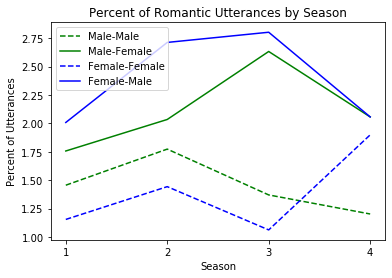

In [138]:
import math
import matplotlib

r['male-male-romanticp']=r['male-male-romantic']/r['tot_utt']*100
r['female-female-romanticp']=r['female-female-romantic']/r['tot_utt']*100
r['female-male-romanticp']=r['female-male-romantic']/r['tot_utt']*100
r['male-female-romanticp']=r['male-female-romantic']/r['tot_utt']*100

year = [1, 2, 3, 4]
mm = r['male-male-romanticp']
mf = r['male-female-romanticp']
ff = r['female-female-romanticp']
fm = r['female-male-romanticp']

plt.plot(year, mm, color='g', linestyle='dashed', label='Male-Male')
plt.plot(year, mf, color='g', label='Male-Female')
plt.plot(year, ff, color='b', linestyle='dashed', label='Female-Female')
plt.plot(year, fm, color='b', label='Female-Male')
plt.xlabel('Season')
plt.ylabel('Percent of Utterances')
plt.title('Percent of Romantic Utterances by Season')
plt.legend()
plt.xticks((1, 2, 3, 4), ('1', '2', '3', '4'), color='k', size=10)
plt.show()


In [77]:
print(r)

   season  tot_utt  male-male-romantic  male-female-romantic  \
0       1     5976                  87                   105   
1       2     5751                 102                   117   
2       3     6495                  89                   171   
3       4     6320                  76                   130   
4       5     6220                   0                     0   
5       6     6458                   0                     0   
6       7     6313                   0                     0   
7       8     6220                   0                     0   
8       9     6329                   0                     0   
9      10     5247                   0                     0   

   female-female-romantic  female-male-romantic  male-male-romanticp  
0                      69                   120             1.455823  
1                      83                   156             1.773605  
2                      69                   182             1.370285  
3          

# Creating Utterance Bar Graphs

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

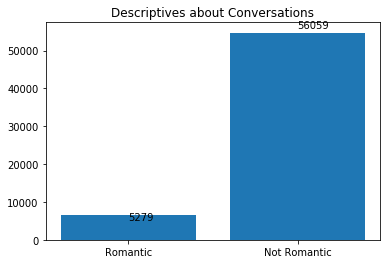

In [13]:
#Simple Statistics
label = [5279, 56059]
height=[romantic, not_romantic]
bars=('Romantic', 'Not Romantic')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Descriptives about Conversations')
for i, v in enumerate(label):
    plt.text(x=i, y =v+.25, s=(v))
plt.show()

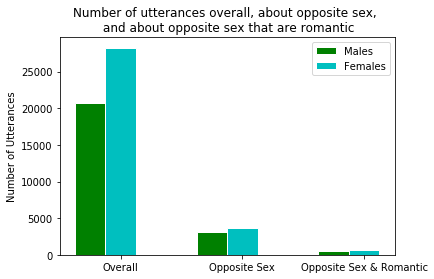

In [14]:
#Comparing Male about Female and Female about Male Conversations (N)
bars1=[male_speaking, male_speaking_about_female, male_speaking_about_female_romantic ]
bars2=[female_speaking, female_speaking_about_male, female_speaking_about_male_romantic ]
barWidth=.25 

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='g', width=barWidth, edgecolor='white', label='Males')
plt.bar(r2, bars2, color='c', width=barWidth, edgecolor='white', label='Females')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Overall', 'Opposite Sex', 'Opposite Sex & Romantic'])
 
# Create legend & Show graphic
plt.title('Number of utterances overall, about opposite sex, \n and about opposite sex that are romantic')
plt.ylabel('Number of Utterances')
plt.xlabel('')
plt.legend()
plt.show()

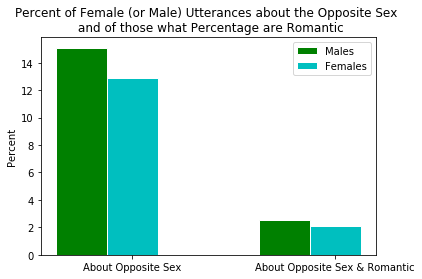

In [15]:
#Comparing Male about Female and Female about Male Conversations (%)
bars1=[perc_male_about_female, perc_male_about_female_rom]
bars2=[perc_female_about_male, perc_female_about_male_rom]
barWidth=.25 

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='g', width=barWidth, edgecolor='white', label='Males')
plt.bar(r2, bars2, color='c', width=barWidth, edgecolor='white', label='Females')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['About Opposite Sex', 'About Opposite Sex & Romantic'])
 
# Create legend & Show graphic
plt.title('Percent of Female (or Male) Utterances about the Opposite Sex \n and of those what Percentage are Romantic')
plt.ylabel('Percent')
plt.xlabel('')
plt.legend()
plt.show()

# Running Statistics on Conversation-Level

In [23]:
convo={}
ff=[]
mm=[]
mf=[]
fm=[]
mfr=[]
fmr=[]
mmr=[]
ffr=[]
rom=[]
total_m=0
total_f=0
total_utt=0
id2=[]
utt_count=0
utterance_ids = transformed_corpus.get_utterance_ids()
current_scene=utterance_ids[0][:11]
current_scene2=1
for uid in utterance_ids:
    utt=transformed_corpus.get_utterance(uid)
    if uid[:11]==current_scene:
        total_utt=total_utt+1
    #male/female speakers
        m2=utt.user.meta["gender"]
        if m2 == "male":
            total_m=total_m+1
        f2=utt.user.meta["gender"]
        if f2 == "female":
            total_f=total_f+1
    #romantic
        rom2=utt.meta["contains_romantic"]
        if rom2==True:    
            rom.append(rom2)
    #female and male about opposite
        mf2=utt.meta["male_about_female"]
        if mf2==True:
            mf.append(mf2)
        fm2=utt.meta["female_about_male"]
        if fm2==True:
            fm.append(fm2)
    #female and male about opposite & romantic
        if mf2==True & rom2==True:
            mfr.append(mf2)
        if fm2==True & rom2==True:
            fmr.append(fm2)        
    #female and male only
        mm2=utt.meta["male_about_male"]
        if mm2==True:
            mm.append(mm2)
        ff2=utt.meta["female_about_female"]
        if ff2==True:
            ff.append(ff2)
    #female and male only about romantic
        if mm2==True & rom2==True:
            mmr.append(mm2)
        if ff2==True & rom2==True:
            ffr.append(ff2)                         
    else: 
        current_scene=uid[:11]
        current_scene2=current_scene2+1
        ff=[]
        mm=[]
        mf=[]
        fm=[]
        rom=[]
        mfr=[]
        fmr=[]
        mmr=[]
        ffr=[]
        total_utt=0
        total_m=0
        total_f=0
          
    convo[current_scene2] = {'total utterances': total_utt, 'total male': total_m, 'total female': total_f, 'male only': mm, 'female only': ff, 'male only romantic': mmr, 'female only romantic': ffr,  'male-female': mf, 'female-male': fm, 'romantic': rom, 'male-female romantic': mfr, 'female-male romantic': fmr,}

In [24]:
#convo.keys()
print(convo[15])

{'total utterances': 17, 'total male': 2, 'total female': 9, 'male only': [], 'female only': [True, True, True], 'male only romantic': [], 'female only romantic': [], 'male-female': [True, True], 'female-male': [True], 'romantic': [True], 'male-female romantic': [], 'female-male romantic': []}


In [39]:
r= [(current_scene2, convo[current_scene2]['total utterances'], convo[current_scene2]['total male'], convo[current_scene2]['total female'], len(convo[current_scene2]['male only']), len(convo[current_scene2]['female only']), len(convo[current_scene2]['romantic']), len(convo[current_scene2]['male only romantic']), len(convo[current_scene2]['female only romantic']), len(convo[current_scene2]['male-female']), len(convo[current_scene2]['female-male']), len(convo[current_scene2]['male-female romantic']), len(convo[current_scene2]['female-male romantic'])) for current_scene2 in convo.keys()]

In [40]:
import pandas as pd
r=pd.DataFrame.from_dict(r)
r.columns=['scene', 'total_utterances', 'total male', 'total female', 'male only', 'female only', 'romantic', 'male only romantic', 'female only romantic', 'male-female', 'female-male', 'male-female romantic', 'female-male romantic']
print(r)

      scene  total_utterances  total male  total female  male only  \
0         1                52          19            21          6   
1         2                55          19            28         10   
2         3                 0           0             0          0   
3         4                16           9             0          5   
4         5                 8           4             4          0   
...     ...               ...         ...           ...        ...   
3094   3095                19           9             1          0   
3095   3096                34          14            14          0   
3096   3097                11           4             5          0   
3097   3098                20           9             8          0   
3098   3099                20           5            11          0   

      female only  romantic  male only romantic  female only romantic  \
0               4         6                   0                     0   
1            

In [41]:
#Number of romantic words
print(len(["adorable","amazing","angel","babe","beau","beautiful","beloved","darling","dearest","enchanting","lover","gorgeous","handsome","heavenly","honey","life-changing","paramour","sweetheart","sweetie","swoon","wonderful","adore","admire","care","cherish","choose","daydream","delight","dream","need","prize","treasure","value","want","worship","yearn","date ","love","kiss","sex","romance","romantic","hug"]))


43


In [42]:
#Female only conversations
f_only = len(r[(r['total male']==0) & (r['total female']>=1)])
print(f_only)
f_mr = len(r[(r['total male']==0) & (r['total female']>=1)  & (r['female-male romantic']>=1)])
print(f_mr)
f_fr = len(r[(r['total male']==0) & (r['total female']>=1)  & (r['female only romantic']>=1)])
print(f_fr)

#Male only conversations
m_only = len(r[(r['total male']>=1) & (r['total female']==0)])
print(m_only)
m_fr = len(r[(r['total male']>=1) & (r['total female']==0)  & (r['male-female romantic']>=1)])
print(m_fr)
m_mr = len(r[(r['total male']>=1) & (r['total female']==0)  & (r['male only romantic']>=1)])
print(m_mr)


624
35
59
428
23
76


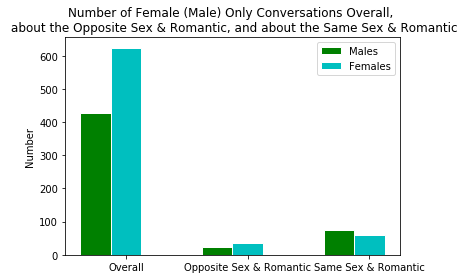

In [44]:
#Comparing Conversations
bars1=[m_only, m_fr, m_mr]
bars2=[f_only, f_mr, f_fr ]
barWidth=.25 

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='g', width=barWidth, edgecolor='white', label='Males')
plt.bar(r2, bars2, color='c', width=barWidth, edgecolor='white', label='Females')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Overall', 'Opposite Sex & Romantic', 'Same Sex & Romantic'])
 
# Create legend & Show graphic
plt.title('Number of Female (Male) Only Conversations Overall, \n about the Opposite Sex & Romantic, and about the Same Sex & Romantic')
plt.ylabel('Number')
plt.xlabel('')
plt.legend()
plt.show()

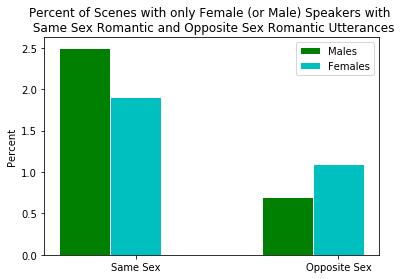

In [45]:
#Comparing Conversations
bars1=[2.5, 0.7]
bars2=[1.9, 1.1]
barWidth=.25 

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='g', width=barWidth, edgecolor='white', label='Males')
plt.bar(r2, bars2, color='c', width=barWidth, edgecolor='white', label='Females')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Same Sex', 'Opposite Sex'])
 
# Create legend & Show graphic
plt.title('Percent of Scenes with only Female (or Male) Speakers with \n Same Sex Romantic and Opposite Sex Romantic Utterances')
plt.ylabel('Percent')
plt.xlabel('')
plt.legend()
plt.show()

# Politeness - Extra Analysis

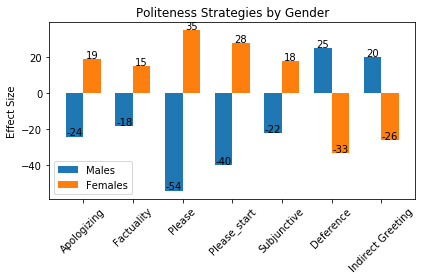

In [16]:
#Politeness 
labels=['Apologizing', 'Factuality', 'Please', 'Please_start', "Subjunctive", 'Deference', 'Indirect Greeting']
female_data=[19, 15, 35, 28, 18, -33, -26]
male_data=[-24, -18, -54, -40, -22, 25, 20]

x = np.arange(len(labels))  # the label locations
width=0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male_data, width, label='Males')
rects2 = ax.bar(x + width/2, female_data, width, label='Females')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Effect Size')
ax.set_title('Politeness Strategies by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,  rotation=45)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()